# **Bayesian and Gaussian Process regression**

    Notebook version: 1.0 (Oct 16, 2015)

    Authors: Miguel Lázaro Gredilla
             Jerónimo Arenas García (jarenas@tsc.uc3m.es)

    Changes: v.1.0 - First version. Python version
    
    Pending changes: 

In [34]:
# Import some libraries that will be necessary for working with data and displaying plots

# To visualize plots in the notebook
%matplotlib inline 

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.io       # To read matlab files
from scipy import spatial
import pylab
pylab.rcParams['figure.figsize'] = 8, 5

# 1. Introduction

In this exercise the student will review several key concepts of Bayesian regression and Gaussian processes.

For the purpose of this exercise, the regression model is

$${s}({\bf x}) = f({\bf x}) + \varepsilon$$

where ${s}({\bf x})$ is the output corresponding to input ${\bf x}$, $f({\bf x})$ is the unobservable latent function, and $\varepsilon$ is white zero-mean Gaussian noise, i.e., $\varepsilon \sim {\cal N}(0,\sigma_\varepsilon^2)$.


### Practical considerations

   - Though sometimes unavoidable, it is recommended not to use explicit matrix inversion whenever possible. For instance, if an operation like ${\mathbf A}^{-1} {\mathbf b}$ must be performed, it is preferable to code it using python $\mbox{numpy.linalg.lstsq}$ function (see http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html), which provides the LS solution to the overdetermined system ${\mathbf A} {\mathbf w} = {\mathbf b}$.
   
   - Sometimes, the computation of $\log|{\mathbf A}|$ (where ${\mathbf A}$ is a positive definite matrix) can overflow available precision, producing incorrect results. A numerically more stable alternative, providing the same result is $2\sum_i \log([{\mathbf L}]_{ii})$, where $\mathbf L$ is the Cholesky decomposition of $\mathbf A$ (i.e., ${\mathbf A} = {\mathbf L}^\top {\mathbf L}$), and $[{\mathbf L}]_{ii}$ is the $i$th element of the diagonal of ${\mathbf L}$.
   
   - Non-degenerate covariance matrices, such as the ones in this exercise, are always positive definite. It may happen, as a consequence of chained rounding errors, that a matrix which was mathematically expected to be positive definite, turns out not to be so. This implies its Cholesky decomposition will not be available. A quick way to palliate this problem is by adding a small number (such as $10^{-6}$) to the diagonal of such matrix.

### Reproducibility of computations

To guarantee the exact reproducibility of the experiments, it may be useful to start your code initializing the seed of the random numbers generator, so that you can compare your results with the ones given in this notebook.

In [35]:
np.random.seed(3)

# 2. Bayesian regression with a linear model

During this section, we will assume the following parametric model for the latent function

$$f({\bf x}) = {\bf x}^\top {\bf w}$$

i.e., a linear model in the observations, where ${\bf w}$ contains the parameters of the model. The <i>a priori</i> distribution of ${\bf w}$ is assumed to be

$${\bf w} \sim {\cal N}({\bf 0}, \sigma_0^2~{\bf I})$$

## 2.1. Synthetic data generation

First, we are going to generate synthetic data (so that we have the ground-truth model) and use them to make sure everything works correctly and our estimations are sensible.

Set parameters $\sigma_0^2 = 2$ and $\sigma_{\varepsilon}^2 = 0.2$. Generate a weight vector $\mbox{true_w}$ with two elements from the <i>a priori</i> distribution of the weights. This vector determines the regression line that we want to find (i.e., the optimum unknown solution).

Generate an input matrix $\mbox{X}$ containing the constant term 1 in all elements of the first column and values between 0 and 2 (included), with a 0.1 step, in the second column.

Finally, generate the output vector ${\mbox s}$ as the product $\mbox{X} \ast \mbox{true_w}$ plus Gaussian noise of pdf ${\cal N}(0,\sigma_\varepsilon^2)$ at each element.

Plot the generated data. You will notice a linear behavior, but the presence of noise makes it hard to estimate precisely the original straight line that generated them (which is stored in $\mbox{true_w}$).

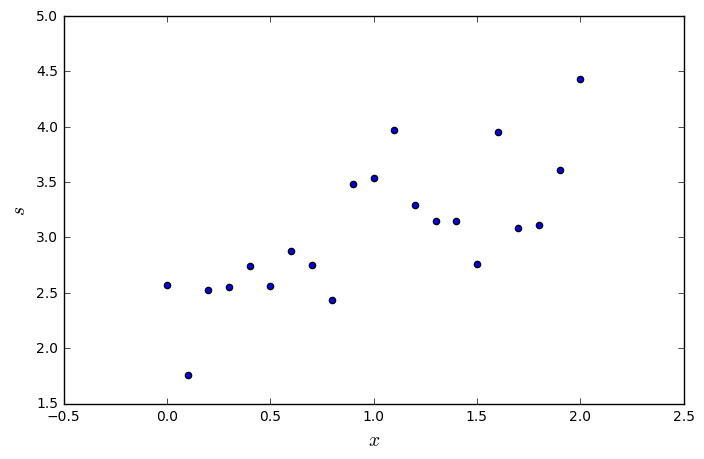

In [36]:
# Parameter settings
sigma_0 = np.sqrt(2)
sigma_eps = np.sqrt(0.2)
dim_x = 2
x_min = 0
x_max = 2
n_points = 21

#Optimum solution
true_w = sigma_0 * np.random.randn(dim_x)

#Training datapoints
X = np.linspace(x_min,x_max,n_points)
col_1 = np.ones( (n_points,) )
Xe = np.vstack( (col_1,X) ).T

s = Xe.dot(true_w) + sigma_eps * np.random.randn(n_points)

#Plot training points
plt.scatter(X, s);
plt.xlabel('$x$',fontsize=14);
plt.ylabel('$s$',fontsize=14);

## 2.2. Posterior pdf of the weight vector

Let us see to which extent it is possible to determine the original straight line from observed data. Knowing that the generative model is linear (i.e., $f({\bf x}) = {\bf x}^\top{\bf w}$, and knowing also the prior pdf of weights $p({\bf w}) = {\cal N}({\bf 0},\sigma_0^2~{\bf I})$ and noise $p(\varepsilon) = {\cal N}(0,\sigma_\varepsilon^2)$, compute the posterior pdf of the weights, $p({\bf w}\mid{\bf s})$.

In [37]:
Cov_w = np.linalg.inv( Xe.T.dot(Xe)/(sigma_eps**2) + np.eye(dim_x,dim_x)/(sigma_0**2) )
mean_w = Cov_w.dot(Xe.T).dot(s)/(sigma_eps**2) 

The results is:

In [38]:
print 'true_w = ' + str(true_w)
print 'mean_w = ' + str(mean_w)
print 'Cov_w = ' + str(Cov_w)

true_w = [ 2.52950265  0.61731815]
mean_w = [ 2.29909556  0.75291393]
Cov_w = [[ 0.03455724 -0.02519798]
 [-0.02519798  0.02531797]]


## 2.3. Sampling regression curves from the posterior

Plot now the functions corresponding to different samples drawn from the posterior distribution of the weight vector. To this end, generate random vectors ${\bf w}_l$ with $l = 1,\dots, 50$, from the posterior density of the weights, $p({\bf w}\mid{\bf s})$, and use them to generate 50 straight lines, $f({\bf x}^\ast) = {{\bf x}^\ast}^\top {\bf w}_l$, with the second component of ${\bf x}^\ast$ between $-1$ and $3$, with step $0.1$.

Plot the original ground-truth straight line, corresponding to $\mbox{true_w}$, along with the $50$ generated straight lines and the original samples, all in the same plot. As you can check, the Bayesian model is not providing a single answer, but instead a density over them, from which we have extracted 50 options.

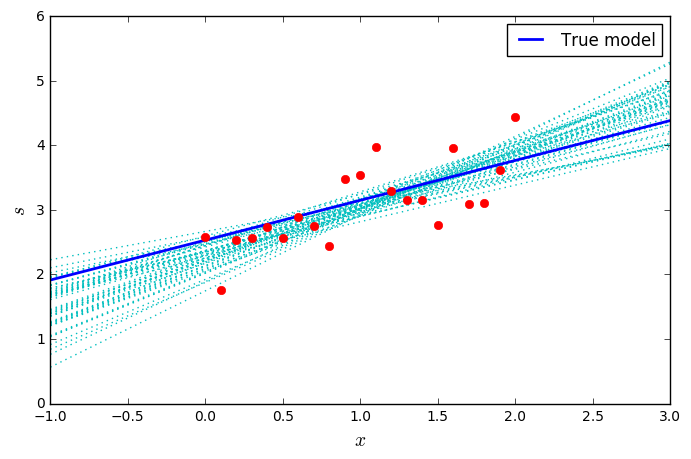

In [42]:
# Definition of the interval for representation purposes 
x2_min = -1
x2_max = 3
step = 0.1

# Input values for representation of the regression curves
X2 = np.arange(x2_min,x2_max+step,step=step)
col_1 = np.ones( (len(X2),) )
X2e = np.vstack( (col_1, X2) ).T

# For drawing weights from the posterior
L = np.linalg.cholesky(Cov_w)

for l in range(50):
    w_l = L.dot(np.random.randn(dim_x)) + mean_w
    plt.plot(X2, X2e.dot(w_l), 'c:');

# Plot as well the training points and the true model
plt.plot(X2, X2e.dot(true_w), 'b', label='True model', linewidth=2);
plt.plot(X,s,'r.',markersize=12);
plt.xlim((x2_min,x2_max));
    
plt.legend(loc='best')
plt.xlabel('$x$',fontsize=14);
plt.ylabel('$s$',fontsize=14);

## 2.4. Plotting the confidence intervals

On top of the previous figure (copy here your code from the previous section), plot functions

$${\mathbb E}\left\{f({\bf x}^\ast)\mid{\bf s}\right\}$$

and

$${\mathbb E}\left\{f({\bf x}^\ast)\mid{\bf s}\right\} \pm 2 \sqrt{{\mathbb V}\left\{f({\bf x}^\ast)\mid{\bf s}\right\}}$$

(i.e., the posterior mean of $f({\bf x}^\ast)$, as well as two standard deviations above and below).

It is possible to show analytically that this region comprises $95.45\%$ probability of the posterior probability $p(f({\bf x}^\ast)\mid {\bf s})$ at each ${\bf x}^\ast$.

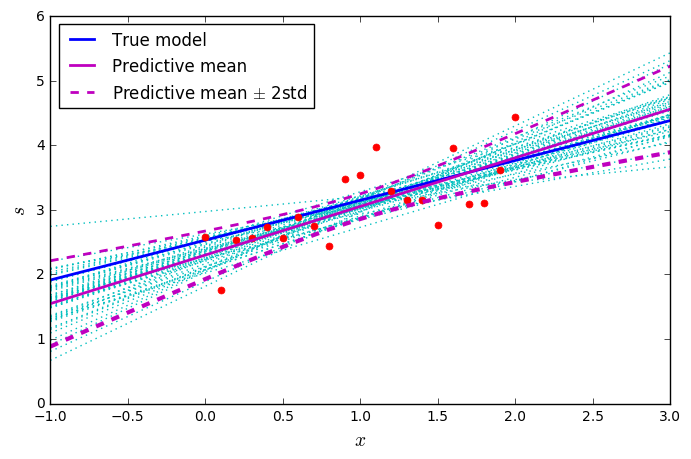

In [53]:
# Definition of the interval for representation purposes 
x2_min = -1
x2_max = 3
step = 0.1

# Input values for representation of the regression curves
X2 = np.arange(x2_min,x2_max+step,step=step)
col_1 = np.ones( (len(X2),) )
X2e = np.vstack( (col_1, X2) ).T

# For drawing weights from the posterior
L = np.linalg.cholesky(Cov_w)

for l in range(50):
    w_l = L.dot(np.random.randn(dim_x)) + mean_w
    plt.plot(X2,X2e.dot(w_l),'c:');

# Plot as well the training points and the true model
plt.plot(X2,X2e.dot(true_w),'b',label='True model',linewidth=2);
plt.plot(X,s,'r.',markersize=10);
plt.xlim((x2_min,x2_max));

#Plot also the posterior mean and posterior mean \pm 2 std
mean_ast = X2e.dot(mean_w)
plt.plot(X2,mean_ast,'m',label='Predictive mean',linewidth=2);

std_ast = np.sqrt(np.diagonal(X2e.dot(Cov_w).dot(X2e.T)))
plt.plot(X2,mean_ast+2*std_ast,'m--',label='Predictive mean $\pm$ 2std',linewidth=2);
plt.plot(X2,mean_ast-2*std_ast,'m--',linewidth=3);
    
plt.legend(loc='best');
plt.xlabel('$x$',fontsize=14);
plt.ylabel('$s$',fontsize=14);

Plot now ${\mathbb E}\left\{s({\bf x}^\ast)\mid{\bf s}\right\} \pm 2 \sqrt{{\mathbb V}\left\{s({\bf x}^\ast)\mid{\bf s}\right\}}$ (note that the posterior means of $f({\bf x}^\ast)$ and $s({\bf x}^\ast)$ are the same, so there is no need to plot it again). Notice that $95.45\%$ of observed data lie now within the newly designated region. These new limits establish a confidence range for our predictions. See how the uncertainty grows as we move away from the interpolation region to the extrapolation areas.

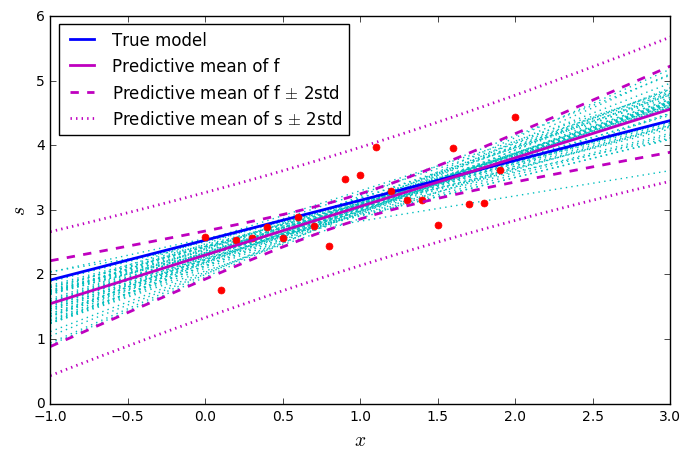

In [52]:
# Definition of the interval for representation purposes 
x2_min = -1
x2_max = 3
step = 0.1

# Input values for representation of the regression curves
X2 = np.arange(x2_min,x2_max+step,step=step)
col_1 = np.ones( (len(X2),) )
X2e = np.vstack( (col_1,X2) ).T

# For drawing weights from the posterior
L = np.linalg.cholesky(Cov_w)

for l in range(50):
    w_l = L.dot(np.random.randn(dim_x)) + mean_w
    plt.plot(X2,X2e.dot(w_l),'c:');

# Plot as well the training points and the true model
plt.plot(X2,X2e.dot(true_w), 'b', label='True model', linewidth=2);
plt.plot(X,s,'r.', markersize=10);
plt.xlim((x2_min, x2_max));

#Plot also the posterior mean and posterior mean \pm 2 std
mean_ast = X2e.dot(mean_w)
plt.plot(X2,mean_ast, 'm', label='Predictive mean of f', linewidth=2);

std_ast = np.sqrt(np.diagonal(X2e.dot(Cov_w).dot(X2e.T)))
plt.plot(X2,mean_ast+2*std_ast, 'm--',label='Predictive mean of f $\pm$ 2std',linewidth=2);
plt.plot(X2,mean_ast-2*std_ast, 'm--',linewidth=2);

std_ast_eps = np.sqrt(np.diagonal(X2e.dot(Cov_w).dot(X2e.T))+ sigma_eps**2)
#Plot now the posterior mean and posterior mean \pm 2 std for s (i.e., adding the noise variance)
plt.plot(X2, mean_ast+2*std_ast_eps, 'm:', label='Predictive mean of s $\pm$ 2std',linewidth=2);
plt.plot(X2, mean_ast-2*std_ast_eps, 'm:', linewidth=2);

plt.legend(loc='best');
plt.xlabel('$x$',fontsize=14);
plt.ylabel('$s$',fontsize=14);

# 3. Bayesian Inference with real data. The stocks dataset.


Once our code has been tested on synthetic data, we will use it with real data. Load and properly normalize data corresponding to the evolution of the stocks of 10 airline companies. This data set is an adaptation of the Stock dataset from http://www.dcc.fc.up.pt/~ltorgo/Regression/DataSets.html, which in turn was taken from the StatLib Repository, http://lib.stat.cmu.edu/

In [3]:
matvar = scipy.io.loadmat('DatosLabReg.mat')
Xtrain = matvar['Xtrain']
Xtest = matvar['Xtest']
Ytrain = matvar['Ytrain']
Ytest = matvar['Ytest']

# Data normalization
mean_x = np.mean(Xtrain,axis=0)
std_x = np.std(Xtrain,axis=0)
Xtrain = (Xtrain - mean_x) / std_x
Xtest = (Xtest - mean_x) / std_x

# Extend input data matrices with a column of 1's
col_1 = np.ones( (Xtrain.shape[0],1) )
Xtrain_e = np.concatenate( (col_1,Xtrain), axis = 1 )

col_1 = np.ones( (Xtest.shape[0],1) )
Xtest_e = np.concatenate( (col_1,Xtest), axis = 1 )

After running this code, you will have inside matrix $\mbox{Xtrain_e}$ an initial column of ones and the evolution of (normalized) price for 9 airlines, whereas vector Ytrain will contain a single column with the price evolution of the tenth airline. The objective of the regression task is to estimate the price of the tenth airline from the prices of the other nine.

## 3.1. Hyperparameter selection

Since the values $\sigma_0$ and $\sigma_\varepsilon$ are no longer known, a first rough estimation is needed (we will soon see how to estimate these values in a principled way).

To this end, we will adjust them using the LS solution to the regression problem:

   - $\sigma_0^2$ will be taken as the average of the square values of ${\hat {\bf w}}_{LS}$
   - $\sigma_\varepsilon^2$ will be taken as two times the average of the square of the residuals when using ${\hat {\bf w}}_{LS}$

In [10]:
w_LS, residuals, rank, s = np.linalg.lstsq(Xtrain_e,Ytrain)
sigma_0 = np.sqrt(np.mean(w_LS**2))
sigma_eps = np.sqrt(2 * np.mean((Ytrain - Xtrain_e.dot(w_LS))**2))

## 3.2. Posterior pdf of the weight vector

Using the previous values for the hyperparameters, compute the <i>a posteriori</i> mean and covariance matrix of the weight vector ${\bf w}$. Instead of two weights there will now be 10.

In [11]:
dim_x = Xtrain_e.shape[1]

Cov_w = np.linalg.inv( Xtrain_e.T.dot(Xtrain_e)/(sigma_eps**2) + np.eye(dim_x,dim_x)/(sigma_0**2) )
mean_w = Cov_w.dot(Xtrain_e.T).dot(Ytrain)/(sigma_eps**2) 

The resulting posterior is:

In [12]:
print 'mean_w = ' + str(mean_w)
print 'Cov_w = ' + str(Cov_w)

mean_w = [[ 47.05815827]
 [  5.00414611]
 [  2.23805657]
 [  0.15284809]
 [ -1.21321506]
 [  1.35020502]
 [ -3.1205305 ]
 [  1.08434917]
 [  0.85755156]
 [  2.24208409]]
Cov_w = [[  1.37708166e-02  -1.90424453e-17   4.70675921e-17  -1.32500190e-17
   -2.73966865e-17  -1.33414845e-17   4.19243381e-18  -3.16103594e-18
    5.29723153e-17  -9.11219682e-18]
 [ -1.90424453e-17   1.61193895e-01   1.19983623e-02   2.52752373e-02
   -2.74399921e-03   2.91979986e-03   3.46489945e-02   9.27404804e-03
   -1.16337869e-01  -1.85649689e-02]
 [  4.70675921e-17   1.19983623e-02   2.11749245e-01  -5.34011223e-02
   -1.23160182e-02  -7.26971855e-02  -6.72052851e-03  -4.46380127e-02
    4.83685664e-02  -7.56631814e-02]
 [ -1.32500190e-17   2.52752373e-02  -5.34011223e-02   6.04494893e-02
    8.63341517e-03   5.27479724e-03  -1.77929599e-02   8.84585833e-03
   -3.36597425e-02   1.97630174e-02]
 [ -2.73966865e-17  -2.74399921e-03  -1.23160182e-02   8.63341517e-03
    9.65083458e-02   1.94374658e-02  -2.7592

## 3.3. Model assessment

In order to verify the performance of the resulting model, compute the posterior mean and variance of each of the test outputs from the posterior over ${\bf w}$. I.e, compute ${\mathbb E}\left\{s({\bf x}^\ast)\mid{\bf s}\right\}$ and $\sqrt{{\mathbb V}\left\{s({\bf x}^\ast)\mid{\bf s}\right\}}$ for each test sample ${\bf x}^\ast$ contained in each row of $\mbox{Xtest}$. Be sure not to use the outputs $\mbox{Ytest}$ at any point during this process.

Store the predictive mean and variance of all test samples in two vectors called $\mbox{m_y}$ and $\mbox{v_y}$, respectively.

In [13]:
m_y = Xtest_e.dot(mean_w)
v_y = np.diagonal(Xtest_e.dot(Cov_w).dot(Xtest_e.T)) + sigma_eps**2

Compute now the mean square error (MSE) and the negative log-predictive density (NLPD) with the following code:

In [14]:
from math import pi

MSE = np.mean((m_y - Ytest)**2)
NLPD = 0.5 * np.mean(((Ytest - m_y)**2)/(np.matrix(v_y).T) + 0.5*np.log(2*pi*np.matrix(v_y).T))


Results should be:

In [15]:
print 'MSE = ' + str(MSE)
print 'NLPD = ' + str(NLPD)

MSE = 6.11353618976
NLPD = 1.33761732312


These two measures reveal the quality of our predictor (with lower values revealing higher quality). The first measure (MSE) only compares the predictive mean with the actual value and always has a positive value (if zero was reached, it would mean a perfect prediction). It does not take into account predictive variance. The second measure (NLPD) takes into account both the deviation and the predictive variance (uncertainty) to measure the quality of the probabilistic prediction (a high error in a prediction that was already known to have high variance has a smaller penalty, but also, announcing a high variance when the prediction error is small won’t award such a good score).

# 4. Non-linear regression with Gaussian Processes

## 4.1. Multidimensional regression

Rather than using a parametric form for $f({\mathbf x})$, in this section we will use directly the values of the latent function that we will model with a Gaussian process

$$f({\mathbf x}) \sim {\cal GP}\left(0,k_f({\mathbf x}_i,{\mathbf x}_j)\right),$$

where we are assuming a zero mean, and where we will use the Ornstein-Uhlenbeck covariance function, which is defined as:

$$k_f({\mathbf x}_i,{\mathbf x}_j) = \sigma_0^2 \exp \left( -\frac{1}{l}\|{\mathbf x}_i-{\mathbf x}_j\|\right)$$

First, we will use the following gross estimation for the hyperparameters:

In [4]:
sigma_0 = np.std(Ytrain)
sigma_eps = sigma_0 / np.sqrt(10)
l = 8

print sigma_0
print sigma_eps

6.5169816971
2.06085056325


As we studied in a previous session, the joint distribution of the target values in the training set, ${\mathbf s}$, and the latent values corresponding to the test points, ${\mathbf f}^\ast$, is given by

$$\left[\begin{array}{c}{\bf s}\\{\bf f}^\ast\end{array}\right]~\sim~{\cal N}\left({\bf 0},\left[\begin{array}{cc}{\bf K} + \sigma_\varepsilon^2 {\bf I}& {\bf K}_\ast^\top \\ {\bf K}_\ast & {\bf K}_{\ast\ast} \end{array}\right]\right)$$

Using this model, obtain the posterior of ${\mathbf s}^\ast$ given ${\mathbf s}$. In particular, calculate the <i>a posteriori</i> predictive mean and standard deviations, ${\mathbb E}\left\{s({\bf x}^\ast)\mid{\bf s}\right\}$ and $\sqrt{{\mathbb V}\left\{s({\bf x}^\ast)\mid{\bf s}\right\}}$ for each test sample ${\bf x}^\ast$.

Obtain the MSE and NLPD and compare them with those obtained Subsection 3.3.

In [8]:
dist = spatial.distance.cdist(Xtrain,Xtrain,'euclidean')
dist_ss = spatial.distance.cdist(Xtest,Xtest,'euclidean')
dist_s = spatial.distance.cdist(Xtest,Xtrain,'euclidean')

K = (sigma_0**2)*np.exp(-dist/l)
K_ss = (sigma_0**2)*np.exp(-dist_ss/l)
K_s = (sigma_0**2)*np.exp(-dist_s/l)

m_y = K_s.dot(np.linalg.inv(K + sigma_eps**2 * np.eye(K.shape[0]))).dot((Ytrain))
print m_y
v_y = np.diagonal(K_ss - K_s.dot(np.linalg.inv(K + sigma_eps**2 * np.eye(K.shape[0]))).dot(K_s.T)) + sigma_eps**2
MSE = np.mean((m_y - Ytest)**2)
NLPD = 0.5 * np.mean(((Ytest - m_y)**2)/(np.matrix(v_y).T) + 0.5*np.log(2*pi*np.matrix(v_y).T))

NameError: name 'Xtrain' is not defined

You should obtain the following results:

In [18]:
print 'MSE = ' + str(MSE)
print 'NLPD = ' + str(NLPD)

MSE = 0.494826685646
NLPD = 0.967323914258


## 4.2. Unidimensional regression

Use now only the first company to compute the non-linear regression. Obtain the posterior
distribution of $f({\mathbf x}^\ast)$ evaluated at the test values ${\mathbf x}^\ast$, i.e, $p(f({\mathbf x}^\ast)\mid {\mathbf s})$.

This distribution is Gaussian, with mean ${\mathbb E}\left\{f({\bf x}^\ast)\mid{\bf s}\right\}$ and a covariance matrix $\text{Cov}\left[f({\bf x}^\ast)\mid{\bf s}\right]$. Sample 50 random vectors from the distribution and plot them vs. the values $x^\ast$, together with the test samples.

These 50 samples of the function space are analogous to the 50 straight lines that were generated in Subsection 2.3. Again, the Bayesian model does not provide a single function, but a pdf over functions, from which we extracted 50 possible functions.

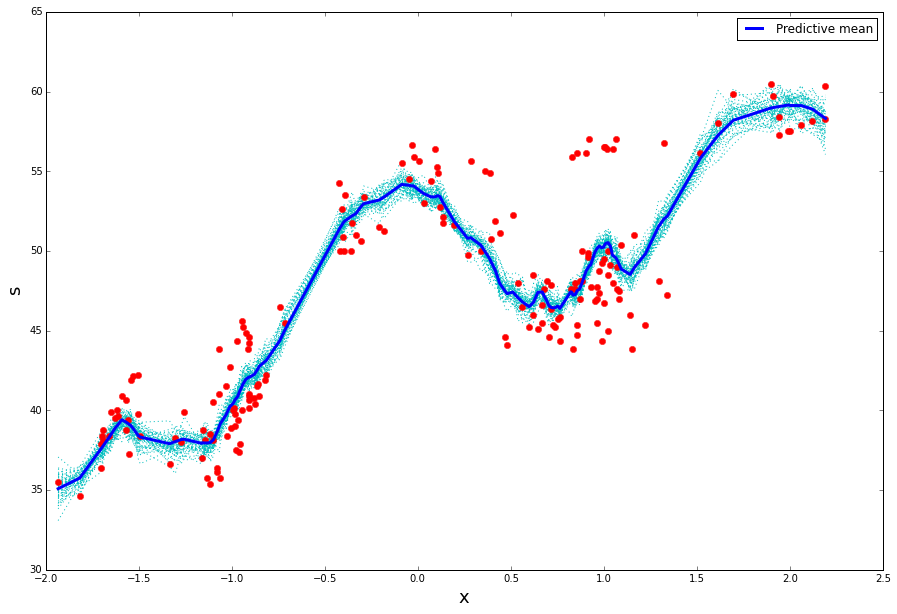

In [19]:
X_1d = np.matrix(Xtrain[:,0]).T
Xt_1d = np.matrix(Xtest[:,0]).T
Xt_1d = np.sort(Xt_1d,axis=0) #We sort the vector for representational purposes

dist = spatial.distance.cdist(X_1d,X_1d,'euclidean')
dist_ss = spatial.distance.cdist(Xt_1d,Xt_1d,'euclidean')
dist_s = spatial.distance.cdist(Xt_1d,X_1d,'euclidean')

K = (sigma_0**2)*np.exp(-dist/l)
K_ss = (sigma_0**2)*np.exp(-dist_ss/l)
K_s = (sigma_0**2)*np.exp(-dist_s/l)
                        
m_y = K_s.dot(np.linalg.inv(K + sigma_eps**2 * np.eye(K.shape[0]))).dot((Ytrain))
v_f = K_ss - K_s.dot(np.linalg.inv(K + sigma_eps**2 * np.eye(K.shape[0]))).dot(K_s.T)

L = np.linalg.cholesky(v_f+1e-10*np.eye(v_f.shape[0]))

for iter in range(50):
    f_ast = L.dot(np.random.randn(len(Xt_1d),1)) + m_y
    plt.plot(np.array(Xt_1d)[:,0],f_ast[:,0],'c:');

# Plot as well the test points
plt.plot(np.array(Xtest[:,0]),Ytest[:,0],'r.',markersize=12);
plt.plot(np.array(Xt_1d)[:,0],m_y[:,0],'b-',linewidth=3,label='Predictive mean');
    
plt.legend(loc='best')
plt.xlabel('x',fontsize=18);
plt.ylabel('s',fontsize=18);

Plot again the previous figure, this time including in your plot the confidence interval delimited by two standard deviations of the prediction, similarly to what was done in Subsection 2.4. You can observe how $95.45\%$ of observed data fall within the designated area.

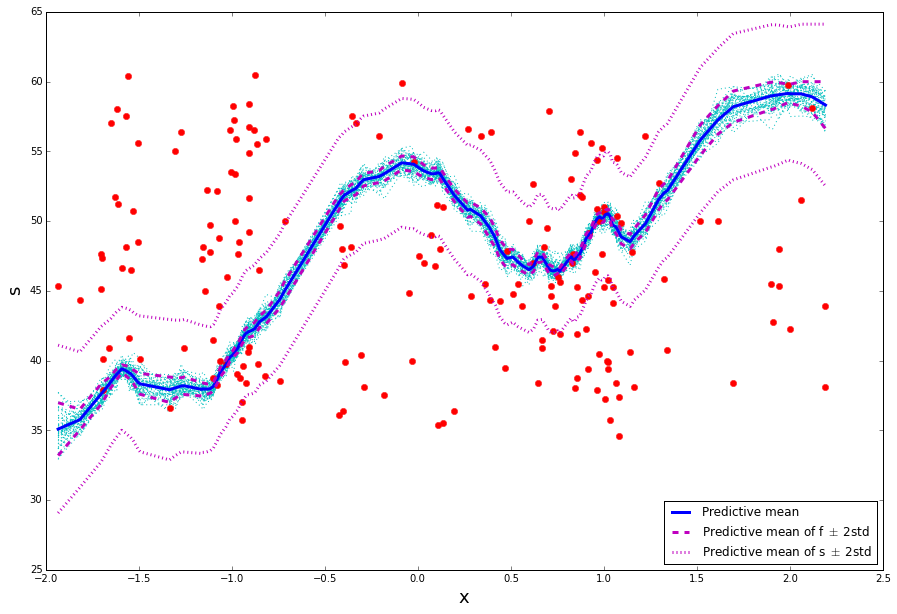

In [20]:
X_1d = np.matrix(Xtrain[:,0]).T
Xt_1d = np.matrix(Xtest[:,0]).T
idx = np.argsort(Xt_1d,axis=0) #We sort the vector for representational purposes
Xt_1d = np.sort(Xt_1d,axis=0)
idx = np.array(idx).flatten().T
Ytest = Ytest[idx]

dist = spatial.distance.cdist(X_1d,X_1d,'euclidean')
dist_ss = spatial.distance.cdist(Xt_1d,Xt_1d,'euclidean')
dist_s = spatial.distance.cdist(Xt_1d,X_1d,'euclidean')

K = (sigma_0**2)*np.exp(-dist/l)
K_ss = (sigma_0**2)*np.exp(-dist_ss/l)
K_s = (sigma_0**2)*np.exp(-dist_s/l)
                        
m_y = K_s.dot(np.linalg.inv(K + sigma_eps**2 * np.eye(K.shape[0]))).dot((Ytrain))
v_f = K_ss - K_s.dot(np.linalg.inv(K + sigma_eps**2 * np.eye(K.shape[0]))).dot(K_s.T)
v_f_diag = np.diagonal(v_f)

L = np.linalg.cholesky(v_f+1e-10*np.eye(v_f.shape[0]))

for iter in range(50):
    f_ast = L.dot(np.random.randn(len(Xt_1d),1)) + m_y
    plt.plot(np.array(Xt_1d)[:,0],f_ast[:,0],'c:');

# Plot as well the test points
plt.plot(np.array(Xtest[:,0]),Ytest[:,0],'r.',markersize=12);
plt.plot(np.array(Xt_1d)[:,0],m_y[:,0],'b-',linewidth=3,label='Predictive mean');
plt.plot(np.array(Xt_1d)[:,0],m_y[:,0]+2*v_f_diag,'m--',label='Predictive mean of f $\pm$ 2std',linewidth=3);
plt.plot(np.array(Xt_1d)[:,0],m_y[:,0]-2*v_f_diag,'m--',linewidth=3);

#Plot now the posterior mean and posterior mean \pm 2 std for s (i.e., adding the noise variance)
plt.plot(np.array(Xt_1d)[:,0],m_y[:,0]+2*v_f_diag+2*sigma_eps,'m:',label='Predictive mean of s $\pm$ 2std',linewidth=3);
plt.plot(np.array(Xt_1d)[:,0],m_y[:,0]-2*v_f_diag-2*sigma_eps,'m:',linewidth=3);

plt.legend(loc='best')
plt.xlabel('x',fontsize=18);
plt.ylabel('s',fontsize=18);

Compute now the MSE and NLPD of the model. The correct results are given below:

In [21]:
MSE = np.mean((m_y - Ytest)**2)
v_y = np.diagonal(v_f) + sigma_eps**2
NLPD = 0.5 * np.mean(((Ytest - m_y)**2)/(np.matrix(v_y).T) + 0.5*np.log(2*pi*np.matrix(v_y).T))
print 'MSE = ' + str(MSE)
print 'NLPD = ' + str(NLPD)

MSE = 6.93366416329
NLPD = 1.61261114765


#5. Model Selection

In [22]:
from scipy.optimize import fmin

def negative_ll(x,*args):
    Xtr = args[0]
    Ytr = args[1]
    dist = spatial.distance.cdist(Xtr,Xtr,'euclidean')
    K = (x[0]**2)*np.exp(-dist/x[1])
    K_reg = K + x[2]**2 * np.eye(K.shape[0])
    K_inv = np.linalg.inv(K_reg)
    return .5 * Ytr.T.dot(K_inv).dot(Ytr) + .5 * np.log(np.linalg.det(K_reg)) + .5 * len(Ytr) * np.log(2*pi)
    
#xopt = fmin(func=negative_ll, x0=np.array([sigma_0, l, sigma_eps]), args=(X_1d,Ytrain))    

#print xopt